# Proyecto Final - Redes Neuronales - Convolucionales
##### Curso: Statistical Learning

## Desarrollo del Problema

**Objetivo general:** Desarollar un programa que me permita clasificar si la foto se trata de una abeja o se trata de una avispa.

### Estrategia de Solución

**Idea principal:**
Uso de Redes Neuronales convolucionales(RNC) para entrenar un modelo que pueda diferenciar abejas de avispas; para se usará Transfer Learning para usar modelos Pre-Entrenados para facilitar el modelado.

**Red base para modelado RNC:**
Existen diferentes arquitecturas para crear RNC, pero para facilitar el trabajo de entrenamiento y busqueda de un modelo óptimo, se usará la arquitectura _Mobilenet V.2_ (creada por Google); esta en particular al ser un esencialmente una versión simplificada de la arquitectura Xception, optimizada para aplicaciones móviles; lo cual supera en rendimiento muchas otras.

**¿Por qué Mobilenet V2.0?**  
MobileNetV2 es una mejora significativa sobre MobileNetV1 e impulsa el estado del arte para el reconocimiento visual móvil, incluida la clasificación, la detección de objetos y la segmentación semántica. MobileNetV2 se lanza como parte de la biblioteca de clasificación de imágenes de TensorFlow-Slim, o puede comenzar a explorar MobileNetV2 de inmediato en Colaboratory. Alternativamente, puede descargar el cuaderno y explorarlo localmente usando Jupyter. 

MobileNetV2 se basa en las ideas de MobileNetV1 [1], utilizando una convolución separable en profundidad como bloques de construcción eficientes. Sin embargo, V2 introduce dos características nuevas en la arquitectura: 1) cuellos de botella lineales entre las capas y 2) conexiones de atajo entre los cuellos de botella1. La estructura básica se muestra a continuación:

<img src="assets/mobilenetV2_arq.png">

MobileNetV2 es un extractor de features muy eficaz para la detección y segmentación de objetos.

MobileNetV2 en su implementación con **Keras** ya incluye modelos pre_entrenados para el reconocimiento de imagenes.
https://keras.io/api/applications/mobilenet/

**Aplicación en Proyecto:**
Usando Keras, con la implementación que tiene para la arquitectura de mobilenet V.2.0, que como explicamos anteriormente, esta optimizada para clasificación de imagenes; se usará para identificar abejas y avispas. La idea general de la arquitectura seria:

<img src="assets/Arquitecture_general.png">

_**Nota:** Observar que no haremos un modelo binario, sino uno de clasificación Multiple; por lo que cual la función de activación en la última Neurona será SOFTMAX._

## Entrenamiento Modelo

Se usarán Redes Neuronales convolucionales (RNC) usando la arquitectura mobilenet_V2, explicada anteriormente. Para ello se usaremos Keras para el entrenamiento de nuesto modelo.

In [1]:
#Cargamos las librerias que nos servirán para el entrenamiento
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2,ResNet50, InceptionV3
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard,EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import time

#### Busqueda de Dataset entrenamiento del Modelo

Buscaremos en Internet por una colección de imagenes que usaremos el modelo; el objetivo es contar con dos datasets, abejas y avispas.

El Dataset utilizado se descargo de la siguiente fuente:  
https://www.kaggle.com/jerzydziewierz/bee-vs-wasp

A Nivel de archivos podemos visualizar los archivos descargados de la siguiente forma:
<img src="assets/imagenfolderdataset.jpg">

_Nota: Las imagenes se dividieron en tres sets: Training, Test, Validation._

#### Setear Parametros

Definición de algunos Hiperparametros y parametros que se usarán durante el proceso de Entrenamiento.

In [2]:
#### Declaración de Parametros
#Learning Rate - Inicial
INIT_LR = 0.0001 #Se Podrá cambiar durante el entrenamiento

#Tamaño de Batch para Pruebas
batch_size = 32
# Tipos de Objetos a Clasificar (2 - Abejas y Avispas)
num_classes = 2
CATEGORIES = ["bee", "wasp"]

# Número de EPOCHS - Entrenamiento
epochs = 20
# Tamaño de la Imagen
IMAGE_SHAPE = (224, 224, 3)

#### Cargamos Dataset 

Procedemos a crear una función que nos permitirá cargar las imagenes que servirán para el entrenamiento.

In [11]:
def Carga_data(IMAGE_SHAPE=IMAGE_SHAPE):
    '''Esta función permite cargar y normalizar las imagenes de nuestro dataset descargado'''
    
    #Ubicación de los Datasets de entrenamiento y Pruebas
    strDataTrain = "Dataset2/Training"
    strDataTest = "Dataset2/Test"
    
    #Las diferentes clases de Objetos que clasificaremos
    CLASS_NAMES = np.array(CATEGORIES)
    
    #preprocesamiento para Entrenamiento con data augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    #preprocesamiento para test
    test_datagen = ImageDataGenerator(rescale=1./255.)
    
    #Creación del Generador del Dataset de Entrenamiento
    train_data_gen = train_datagen.flow_from_directory(directory=strDataTrain, batch_size=batch_size,
                                                        classes=list(CATEGORIES), target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                        shuffle=True)
    #Creación del Generador del Dataset de Test
    test_data_gen = test_datagen.flow_from_directory(directory=strDataTest, batch_size=batch_size, 
                                                        classes=list(CATEGORIES), target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                        shuffle=True)
    return train_data_gen, test_data_gen, CLASS_NAMES

Probamos la función recien creada.

In [4]:
#Prueba de Función de Carga
train_generator, test_generator, class_names = Carga_data()

print("Datos Cargados para Entrenamiento")
print("Número de Imagenes Cargadas= {}",format(train_generator.samples+test_generator.samples))
print("Número de Imagenes Cargadas para Entrenamiento= {}",format(train_generator.samples))
print("Número de Imagenes Cargadas para Test= {}",format(test_generator.samples))

Found 5292 images belonging to 2 classes.
Found 1850 images belonging to 2 classes.
Datos Cargados para Entrenamiento
Número de Imagenes Cargadas= {} 7142
Número de Imagenes Cargadas para Entrenamiento= {} 5292
Número de Imagenes Cargadas para Test= {} 1850


#### Creación de Modelo

Procedemos a crear una función que nos permitirá definir el modelo que vamos a pasar por el entrenamiento.

In [8]:
def create_model(input_shape,Model_Type="MobileNetV2", layers_except=4,lr= INIT_LR, DecayLR= False):
    '''Función que nos permitirá definir nuestro Modelo de Red Convolucional'''
    
    #Se comparará con otros modelos para ver cual tiene los mejores resultados
    #Model_Type - MobileNetV2, ResNet50, InceptionV3
    #Se dejará variable el Número de Capas del Modelo Preentrenado que será sujeto al entrenamiento
    #layers_except - Por Defecto le dejamos 4
    
    # Cargamos Modelo MobileNetV2 o el Elegido
    if Model_Type =="ResNet50":
        model = MobileNetV2(input_shape=input_shape)
    elif Model_Type =="InceptionV3":
        model = InceptionV3(input_shape=input_shape)
    else: ##
        model = MobileNetV2(input_shape=input_shape)
    # Quitamos la última Capa (Fully Connected)
    model.layers.pop()
    # Congelamos todos los pesos del modelo, excepto las "layers_except" ultimas capas
    for layer in model.layers[:-layers_except]:
        layer.trainable = False
        
    # Construimos la última capa del Modelo - Para nuestra Clasificación
    output = Dense(num_classes, activation="softmax")
    # Conectamos esta capa densa (Fully Connected al Modelo)
    output = output(model.layers[-1].output)
    model = Model(inputs=model.inputs, outputs=output)
    # Imprimimos como queda la arquitectura
    model.summary()
    # training the model using adam optimizer
    if DecayLR:
        opt = Adam(lr=lr, decay=lr / epochs)
    else: 
        opt = Adam(lr=lr)
    #Compilamos nuestro modelo
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

#### Entrenamiento del Modelo

Creamos una función que nos permitirá el entrenamiento del Modelo Elegido.

Tomar en Consideración:
* Se usará **Tensorboard** _(por medio de un callback)_ para ir almacenando las metricas del entrenamiento.
* Se usará **Checkpoints** _(por medio de un callback)_ para almacenar los mejores modelos entrenados, y no volver a repetir entrenamientos.
* Se implementará **Early Stop** _(por medio de un callback)_ para detener el entrenamiento al no mejorar despues de N Epochs.

In [13]:
def Train_model(Model_Type="MobileNetV2",layers_except=4,lr= INIT_LR, DecayLR= False,IMAGE_SHAPE=IMAGE_SHAPE):
    '''Función Generica que nos permitirá el entrenamiento del Modelo Compilado'''
    
    #################################
    #Carga de Data y Modelo
    ################################
    # Cargamos la data para el Modelo
    train_generator, validation_generator, class_names = Carga_data(IMAGE_SHAPE)
    # Construimos el Modelo
    model=create_model(input_shape=IMAGE_SHAPE,Model_Type=Model_Type, layers_except=layers_except,lr=lr,DecayLR= DecayLR)
    
    # Nombre Modelo Entrenado - para Checkpoints y log tensorboard
    model_name = Model_Type+"_Lr="+str(lr)+"_DecayLR="+str(DecayLR)+"LayersE="+str(layers_except)
    
    #########################
    # Callbacks
    #########################
    #CallBack para almacenar el Log en Tensorboard
    strConf=time.strftime("%Y%m%d") + "_"+time.strftime("%H%M%S")+model_name
    tensorboard = TensorBoard(log_dir =os.path.join("logsP2", model_name),histogram_freq = 1,profile_batch = '500,520')
    #CallBack para almacenar el log en 
    checkpoint = ModelCheckpoint(os.path.join("CheckpointsP2", f"{model_name}" + "-loss-{val_loss:.2f}.h5"),
                                save_best_only=True,
                                verbose=1)
    #Callbak para Early Stopping
    EarlyStop = EarlyStopping(monitor='loss', patience=3)
    
    # Sino esta creado el Folder para los checkpoints- Lo creamos
    if not os.path.isdir("CheckpointsP2"):
        os.mkdir("CheckpointsP2")
    
    #########################
    # Entrenamiento
    #########################
    # Numero de pasos por EPOCHS
    training_steps_per_epoch = np.ceil(train_generator.samples / batch_size)
    validation_steps_per_epoch = np.ceil(validation_generator.samples / batch_size)
    # Entrenamos el Model (FIT)
    history=model.fit(train_generator, steps_per_epoch=training_steps_per_epoch,
                        validation_data=validation_generator, validation_steps=validation_steps_per_epoch,
                        epochs=epochs, verbose=1, callbacks=[tensorboard, checkpoint,EarlyStop])
    #Devolvemos el modelo Entrenado y la historia del entrenamiento
    return model,history

#### Pruebas de Modelos

Para dejar constancia de algunas pruebas realizadas, se muestra a continuación la ejecución del entrenamiento para las diferentes arquitecturas(MobileNetV2, ResNet50, InceptionV3),usando los parametros base (por defecto) para establecer un baseline del comportamiento.

1. Prueba Modelo MobileNetV2

In [45]:
model,history=Train_model(Model_Type="MobileNetV2")

Found 5292 images belonging to 2 classes.
Found 1850 images belonging to 2 classes.
Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__

Epoch 1/20
166/166 [==============================] - ETA: 0s - loss: 0.6879 - accuracy: 0.5565
Epoch 00001: val_loss improved from inf to 0.66086, saving model to CheckpointsP2\MobileNetV2_Lr=0.0001_DecayLR=FalseLayersE=4-loss-0.66.h5
166/166 [==============================] - 624s 4s/step - loss: 0.6879 - accuracy: 0.5565 - val_loss: 0.6609 - val_accuracy: 0.7568
Epoch 2/20
166/166 [==============================] - ETA: 0s - loss: 0.6738 - accuracy: 0.6521
Epoch 00002: val_loss improved from 0.66086 to 0.64172, saving model to CheckpointsP2\MobileNetV2_Lr=0.0001_DecayLR=FalseLayersE=4-loss-0.64.h5
166/166 [==============================] - 623s 4s/step - loss: 0.6738 - accuracy: 0.6521 - val_loss: 0.6417 - val_accuracy: 0.7362
Epoch 3/20
166/166 [==============================] - ETA: 0s - loss: 0.6634 - accuracy: 0.6704
Epoch 00003: val_loss improved from 0.64172 to 0.63467, saving model to CheckpointsP2\MobileNetV2_Lr=0.0001_DecayLR=FalseLayersE=4-loss-0.63.h5
166/166 [===========

Mostramos los resultados del Entrenamiento en Tensorboard.

**Rendimiento:**
<img src="assets/profilemobilenettest.jpg">
**Metricas (Scalars):**
<img src="assets/metricsmobilenettest.jpg">

Tambien es facilmente visualizable por medio del History.

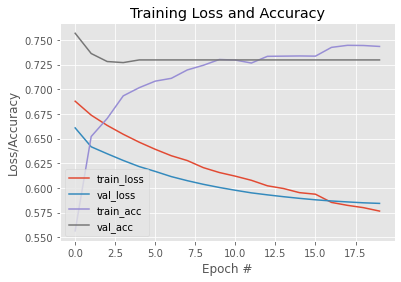

In [50]:
# Graficamos la perdida(loss) y exactitud(accuracy) de la data de entrenamiento y pruebas
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

Mostramos como quedan los checkpoints almacenados, para en algún momento ya utilizar estos modelos ya entrenados.
<img src="assets/mobilenetcheckpoints.jpg">

Mostramos como quedan los checkpoints almacenados, para en algún momento ya utilizar estos modelos ya entrenados.


2. Prueba Modelo ResNet50.

In [7]:
model,history=Train_model(Model_Type="ResNet50")

Found 5292 images belonging to 2 classes.
Found 1850 images belonging to 2 classes.
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
___

Epoch 1/20
166/166 [==============================] - ETA: 0s - loss: 0.6875 - accuracy: 0.5501
Epoch 00001: val_loss improved from inf to 0.66488, saving model to CheckpointsP2\ResNet50_Lr=0.0001_DecayLR=FalseLayersE=4-loss-0.66.h5
166/166 [==============================] - 715s 4s/step - loss: 0.6875 - accuracy: 0.5501 - val_loss: 0.6649 - val_accuracy: 0.7151
Epoch 2/20
166/166 [==============================] - ETA: 0s - loss: 0.6745 - accuracy: 0.6595
Epoch 00002: val_loss improved from 0.66488 to 0.64742, saving model to CheckpointsP2\ResNet50_Lr=0.0001_DecayLR=FalseLayersE=4-loss-0.65.h5
166/166 [==============================] - 707s 4s/step - loss: 0.6745 - accuracy: 0.6595 - val_loss: 0.6474 - val_accuracy: 0.7119
Epoch 3/20
166/166 [==============================] - ETA: 0s - loss: 0.6635 - accuracy: 0.6867
Epoch 00003: val_loss improved from 0.64742 to 0.63927, saving model to CheckpointsP2\ResNet50_Lr=0.0001_DecayLR=FalseLayersE=4-loss-0.64.h5
166/166 [====================

Mostramos los resultados del Entrenamiento en Tensorboard.

**Rendimiento:**
<img src="assets/profileResNet50.jpg">
**Metricas (Scalars):**
<img src="assets/metricsResnet.jpg">

Tambien es facilmente visualizable por medio del History.

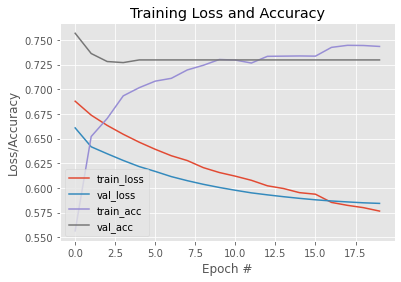

In [50]:
# Graficamos la perdida(loss) y exactitud(accuracy) de la data de entrenamiento y pruebas
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

Mostramos como quedan los checkpoints almacenados, para en algún momento ya utilizar estos modelos ya entrenados.
<img src="assets/Resnet50checkpoints.jpg">

3. Prueba Modelo InceptionV3.

In [14]:
model,history=Train_model(Model_Type="InceptionV3",IMAGE_SHAPE=(299, 299, 3))

Found 5292 images belonging to 2 classes.
Found 1850 images belonging to 2 classes.
96116736/96112376 [==============================] - 37s 0us/step
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (Non

Epoch 1/20
166/166 [==============================] - ETA: 0s - loss: 0.6902 - accuracy: 0.5433
Epoch 00001: val_loss improved from inf to 0.69254, saving model to CheckpointsP2\InceptionV3_Lr=0.0001_DecayLR=FalseLayersE=4-loss-0.69.h5
166/166 [==============================] - 1729s 10s/step - loss: 0.6902 - accuracy: 0.5433 - val_loss: 0.6925 - val_accuracy: 0.4935
Epoch 2/20
166/166 [==============================] - ETA: 0s - loss: 0.6869 - accuracy: 0.5484
Epoch 00002: val_loss improved from 0.69254 to 0.69013, saving model to CheckpointsP2\InceptionV3_Lr=0.0001_DecayLR=FalseLayersE=4-loss-0.69.h5
166/166 [==============================] - 1563s 9s/step - loss: 0.6869 - accuracy: 0.5484 - val_loss: 0.6901 - val_accuracy: 0.5703
Epoch 3/20
166/166 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.5486
Epoch 00003: val_loss improved from 0.69013 to 0.68781, saving model to CheckpointsP2\InceptionV3_Lr=0.0001_DecayLR=FalseLayersE=4-loss-0.69.h5
166/166 [========

Mostramos los resultados del Entrenamiento en Tensorboard.

**Rendimiento:**
<img src="assets/profileInception.jpg">
**Metricas (Scalars):**
<img src="assets/metricsInception.jpg">

Tambien es facilmente visualizable por medio del History.

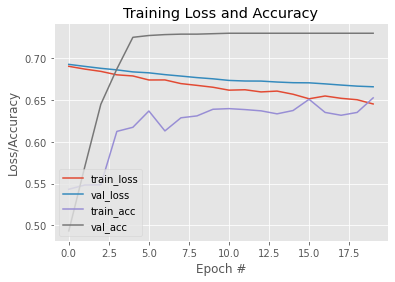

In [15]:
# Graficamos la perdida(loss) y exactitud(accuracy) de la data de entrenamiento y pruebas
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

Mostramos como quedan los checkpoints almacenados, para en algún momento ya utilizar estos modelos ya entrenados.
<img src="assets/Inceptioncheckpoints.jpg">

Mostramos como quedan los checkpoints almacenados, para en algún momento ya utilizar estos modelos ya entrenados.


### Mejor Modelo Entrenado

Despues de varias pruebas realizadas, el modelo que mejor se adapta es el siguiente.

_**Nota:**No se colocan todas las pruebas realizadas para simplificar el notebook, además en la ejecución de pruebas al experimientar con diferentes parametros estar dejando de todo se vuelve un poco inmanejable._

In [91]:
model,history=Train_model(Model_Type="MobileNetV2",lr= 0.0005)

Found 5292 images belonging to 2 classes.
Found 1850 images belonging to 2 classes.
Model: "functional_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__

Epoch 1/20
177/177 [==============================] - ETA: 0s - loss: 0.6692 - accuracy: 0.6555
Epoch 00001: val_loss improved from inf to 0.63723, saving model to CheckpointsP2\MobileNetV2_Lr=0.0005_DecayLR=FalseLayersE=4-loss-0.64.h5
177/177 [==============================] - 437s 2s/step - loss: 0.6692 - accuracy: 0.6555 - val_loss: 0.6372 - val_accuracy: 0.7005
Epoch 2/20
177/177 [==============================] - ETA: 0s - loss: 0.6243 - accuracy: 0.7101
Epoch 00002: val_loss improved from 0.63723 to 0.62221, saving model to CheckpointsP2\MobileNetV2_Lr=0.0005_DecayLR=FalseLayersE=4-loss-0.62.h5
177/177 [==============================] - 438s 2s/step - loss: 0.6243 - accuracy: 0.7101 - val_loss: 0.6222 - val_accuracy: 0.6946
Epoch 3/20
177/177 [==============================] - ETA: 0s - loss: 0.5977 - accuracy: 0.7207
Epoch 00003: val_loss improved from 0.62221 to 0.61787, saving model to CheckpointsP2\MobileNetV2_Lr=0.0005_DecayLR=FalseLayersE=4-loss-0.62.h5
177/177 [===========

_Nota: Vemos que el modelo con la data de Training consiguio una exactitud (Accuracy) del 77%, lo cual esta bien, no lo suficiente, pero la similitud entre estos dos objetos me esta complicando un poco encontrar el modelo adecuado._

#### Almacenamos el Modelo entrenado

Se almacena el modelo entrenado para que pueda ser utilizado posteriormente para predicción.

In [92]:
model.save("finalModels/detector_bee_wasp.model", save_format="h5")

_Nota: Tambien se pudieron utilizar los checkpoints ya almacenados._

### Visualización de Filtros y Feature Map

Tal como es requerido, se mostrará los filtros (Kernels) y Feature map para algunas de las capas convolucionales.

*_Nota: No se mostrarán todas las capas, dado que para la arquitectura mobilenetv2 tiene muchas capas de convolucion, se mostraran las más relevantes_

1. Mostramos las capas donde se realiza convolución.

In [73]:
#Listamos las capas de convolución
for layer in model.layers:
    # Verificamos si es una capa convolucional
    if 'Conv2D' not in str(type(layer)):
        continue
    print("Nombre="+layer.name+", Tipo="+str(type(layer)))

#Almacenamos la información de las capas en un diccionario
layer_dict = dict([(layer.name, layer) for layer in model.layers])

Nombre=Conv1, Tipo=<class 'tensorflow.python.keras.layers.convolutional.Conv2D'>
Nombre=expanded_conv_depthwise, Tipo=<class 'tensorflow.python.keras.layers.convolutional.DepthwiseConv2D'>
Nombre=expanded_conv_project, Tipo=<class 'tensorflow.python.keras.layers.convolutional.Conv2D'>
Nombre=block_1_expand, Tipo=<class 'tensorflow.python.keras.layers.convolutional.Conv2D'>
Nombre=block_1_depthwise, Tipo=<class 'tensorflow.python.keras.layers.convolutional.DepthwiseConv2D'>
Nombre=block_1_project, Tipo=<class 'tensorflow.python.keras.layers.convolutional.Conv2D'>
Nombre=block_2_expand, Tipo=<class 'tensorflow.python.keras.layers.convolutional.Conv2D'>
Nombre=block_2_depthwise, Tipo=<class 'tensorflow.python.keras.layers.convolutional.DepthwiseConv2D'>
Nombre=block_2_project, Tipo=<class 'tensorflow.python.keras.layers.convolutional.Conv2D'>
Nombre=block_3_expand, Tipo=<class 'tensorflow.python.keras.layers.convolutional.Conv2D'>
Nombre=block_3_depthwise, Tipo=<class 'tensorflow.python.k

2. Creamos Funciones para graficar los kernels (Filtros) y los features maps.

In [77]:
import matplotlib.pyplot as plt

def show_filters(layer_name):
    '''Función que nos ayudará a mostrar los filtros(Kernels) para una capa especifica'''
    #Tomamos los pesos de los filtros
    Kfilters = layer_dict[layer_name].get_weights()[0]
    
    # Normalizamos los datos del filtro en el rango de 0 a 1 para que se puedan visualizar
    f_min, f_max = np.amin(Kfilters), np.amax(Kfilters)
    filters = (Kfilters - f_min) / (f_max - f_min)

    # Si el número de Filtros excede los 6, solo mostramos 6 (para los tres canales)
    # Por simplicidad
    if(Kfilters.shape[3]>6):
        n_filters, index = 6, 1
    else: #Se deja el número de Filtros que tiene
        n_filters, index = Kfilters.shape[3], 1
    
    #Seteamos el tamaño del grafico
    f, axes = plt.subplots(n_filters, 3, figsize=(15, 15), sharex=False)
    
    #Recorremos los filtros y los mostramos graficamente
    for i in range(n_filters):
        f = filters[:, :, :, i]
        index = 0
        # Graficamos cada Canal por Separado (RGB)
        for j in range(3):
            if n_filters!=1: #Un Único Filtro
                axes[i,index].set_xticks([])
                axes[i,index].set_yticks([])
                axes[i,index].imshow(f[:, :, j], cmap='viridis')
            else:
                axes[index].set_xticks([])
                axes[index].set_yticks([])
                axes[index].imshow(f[:, :, j], cmap='viridis')
            index += 1

    plt.show()

In [78]:
def show_Featuremap(layer_name):
    
    #Creamos una instancia del Modelo, hasta la capa que necesitamos mostrar
    MODEL = Model(inputs=model.inputs, outputs=layer_dict[layer_name].output)

    # Preparamos la imagen para muestra
    image = load_img('Dataset2/Training/bee/52033120_49a69b55c0_n.jpg', target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    #aplicamos el Modelo para la imagen
    feature_maps = MODEL.predict(image)
    
    # Si el número de Imagenes excede los 9, solo mostramos 9
    # Por simplicidad
    if(feature_maps.shape[3]>9):
        n_images, index = 9, 1
    else: #Se deja el número de Filtros que tiene
        n_images, index = feature_maps.shape[3], 1
    
    #Indice de la imagen
    index = 1
    
    #Seteamos el tamaño del grafico
    f, axes = plt.subplots(n_images//3, 3, figsize=(10, 10), sharex=False)
    i,pos=0,0
    for _ in range(n_images):        
        axes[i,pos].set_xticks([])
        axes[i,pos].set_yticks([])
        axes[i,pos].imshow(feature_maps[0, :, :, index-1], cmap='viridis')

        index += 1
        if pos<2:
            pos=pos+1
        else:
            pos=0
            i+=1

    plt.show()

3. Mostramos los filtros y los feature maps de algunas capas

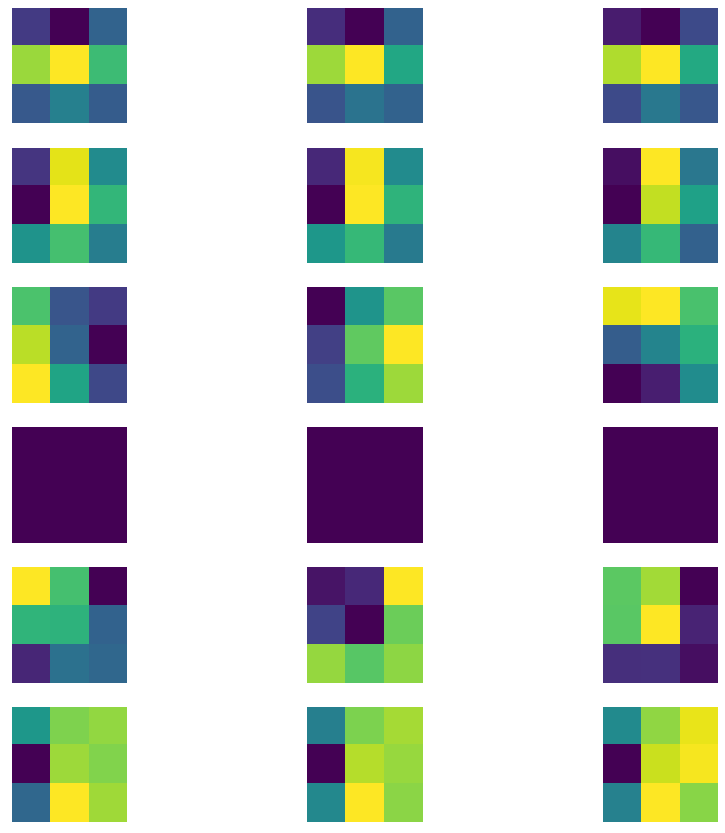

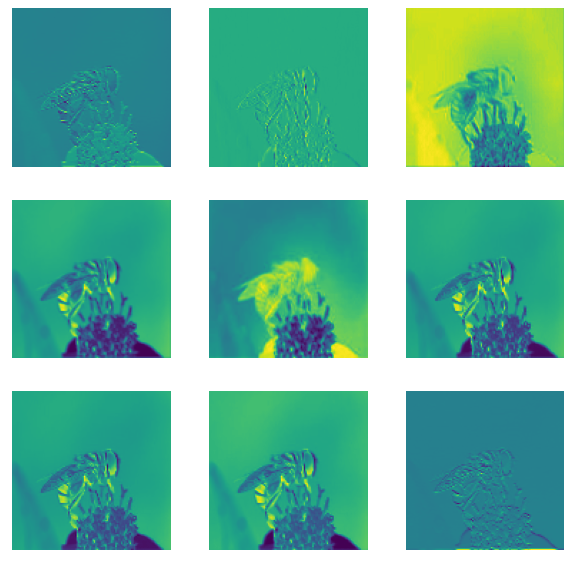

In [79]:
show_filters("Conv1")
show_Featuremap("Conv1")

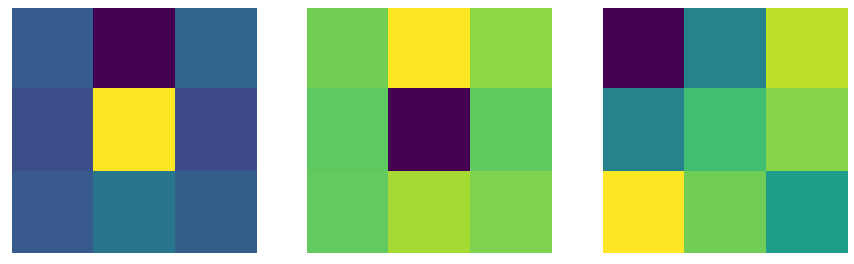

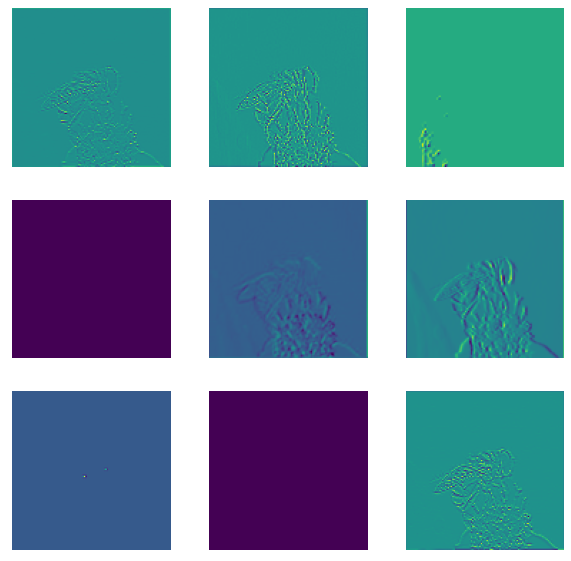

In [80]:
show_filters("expanded_conv_depthwise")
show_Featuremap("expanded_conv_depthwise")

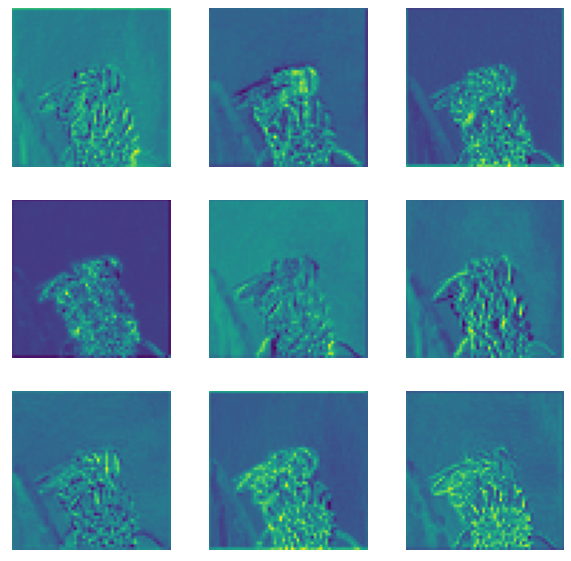

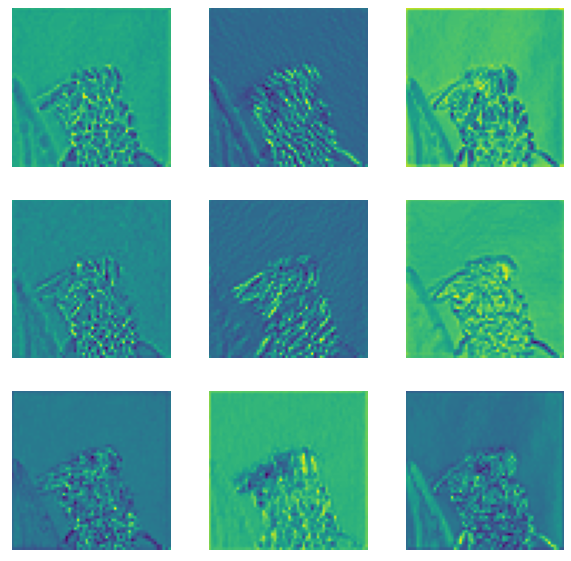

In [84]:
#Mostramos los feature maps de otras capas
show_Featuremap("block_1_project")
show_Featuremap("block_3_expand")

### Cross-Validation _(Prueba Deployment)_

Ya se entreno el modelo y ya se ajustaron los hiperparametros para tener buenos resultados con la data de entrenamiento y con la data de Test; ahora para realizar una validación cruzada (cross-validation) y ver la capacidad de predicción del modelo sobre datos nunca vistos.

_**Nota:** Se cargará el modelo almacenado y no se usará el modelo cargado en memoria, con dos objetivos:_
* _Mostrar el Deployment del modelo._
* _No depender de la ejecución de todo el notebook para realizar la comprobación_

1. Cargamos el modelo ya entrenado.

In [54]:
##Cargamos el Modelo Entrenado
from tensorflow.keras.models import load_model

#Cargamos nuestros modelo entrenado para la detección de mascarrillas
Clasification_Model = load_model("finalModels/detector_bee_wasp.model")

2. Cargamos los datos para la validación.

In [55]:
#Definimos el Directorio donde se encuentran las imagenes
DIRECTORY = r"Dataset2/Validation"

#En estos arreglos almacenaremos las imagenes para la validación del modelo
originalImage = [] #Se dejará este arreglo como almacenamiento de la imagen original cargada
                   #Ya que al usar Keras preprocesamos la imagen y la obtención de la imagen original se complica
data = [] #Aquí se almacenará el dataset ya cargado y preprocesado
labels = [] #Labels o Categorias de la imagen -> "bee", "wasp"

#Recorremos cada categoria
for category in CATEGORIES:
    #Se arma el Path con la ubicación de las imagenes de acuerdo a la categoria
    path = os.path.join(DIRECTORY, category)
    #Por cada imagen encontrada
    for img in os.listdir(path):
        #Se arma el path completo de la imagen
        img_path = os.path.join(path, img)
        #Se carga la imagen -  Se busca un tamaño de 224 por 224
        #De este tamaño son las requeridas para la RNC MobileNet_V2
        image = load_img(img_path, target_size=(224, 224))
        #Se Transforma la imagen en un arreglo
        image = img_to_array(image)
        #Se almacena la imagen original - Como referencia
        originalImage.append(image.copy())
        #Se prepocerá la imagen para la arquitectura mobilenet_v2
        image = preprocess_input(image)
        
        #Se adjuntan las imagenes y labes a los arreglos
        data.append(image)
        labels.append(category)
        
# usamos one-hot encoding en los labels - Ya que Keras no procesa clasificación usando Texto
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

#Convertimos los arreglos en Tensores de Numpy para facilitar la operación con ellos
originalImage=np.array(originalImage, dtype="int32")
data = np.array(data, dtype="float32")
labels = np.array(labels)

3. Realizamos la predicción con los datos de Validación.

In [59]:
#usamos el Modelo ya entrenado para predecir los datos de Validación.
y_hat = Clasification_Model.predict(data, batch_size=batch_size)

In [60]:
#Al ser Softmax la función de activación de la última neurona, nos devolverá una probabilidad
#Tomamos el dato con la mayor probabilidad
y_hat = np.argmax(y_hat, axis=1)

4. Mostramos las metricas de la evaluación

In [61]:
from sklearn.metrics import classification_report

#Imprimimos el Reporte de Clasificación
print(classification_report(labels.argmax(axis=1), y_hat,target_names=lb.classes_))

              precision    recall  f1-score   support

         bee       0.50      0.00      0.01       284
        wasp       0.71      1.00      0.83       700

    accuracy                           0.71       984
   macro avg       0.61      0.50      0.42       984
weighted avg       0.65      0.71      0.59       984



_Nota: En la Data de Cross-Validation tambien se consiguen resultados muy buenos con el clasificador_

5. Mostramos algunas imagenes con la predicción dada por el modelo.

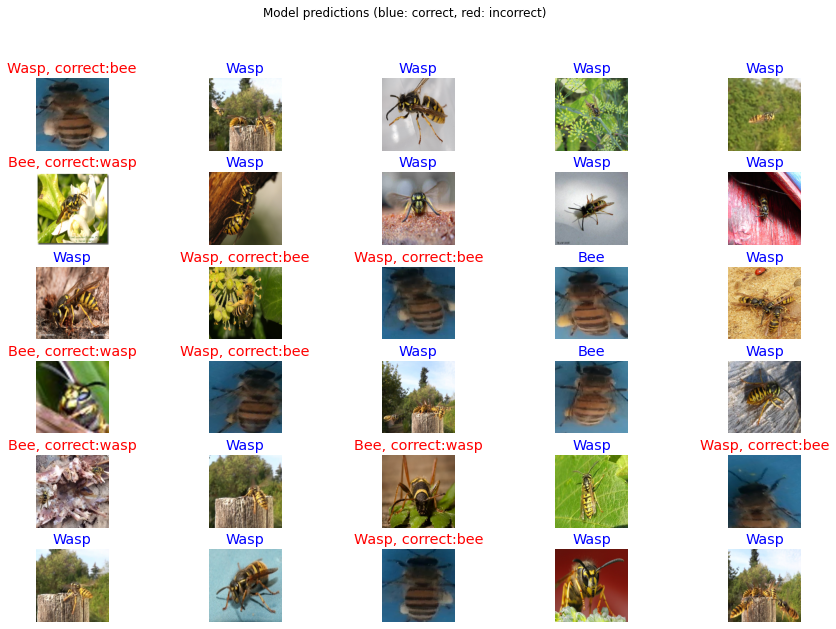

In [71]:
#Escogemos 30 imagenes random - del Lote de Validación
batch_size=30 #30 Imagenes a Mostrar
randon= np.linspace(0, len(data), num=len(data)+1)
idx =np.random.choice(randon, batch_size).astype('int')

#Obtenemos las imagenes a mostrar
image_batch = originalImage[idx]
label_batch = labels[idx]
#Convertimos los labels en Texto de Acuerdo a la categoria que pertenezcan
label_batch = [CATEGORIES[np.argmax(label_batch[i])] for i in range(batch_size)]
# Hacemos la predicción con el modelo
predicted_class_names = model.predict(image_batch)
predicted_ids = [np.argmax(predicted_class_names[i]) for i in range(batch_size)]
# Convertimos las predicción al label que corresponda de acuerdo a su categoria
predicted_class_names = np.array([class_names[id] for id in predicted_ids])
# Mostramos las imagenes
plt.figure(figsize=(15,10))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    if predicted_class_names[n] == label_batch[n]:
        color = "blue"
        title = predicted_class_names[n].title()
    else:
        color = "red"
        title = f"{predicted_class_names[n].title()}, correct:{label_batch[n]}"
    plt.title(title, color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")
plt.show()